## 特徴量の重要度シュミレーション

In [1]:
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
warnings.simplefilter("ignore")

In [2]:
from sklearn.model_selection import train_test_split

def generate_simulation_data(N, beta, mu, Sigma):
    """線形のシミュレーションデータを生成し、訓練データとテストデータに分割する
    
    Args: 
        N: インスタンスの数
        beta: 各特徴量の傾き
        mu: 各特徴量は多変量正規分布から生成される。その平均。
        Sigma: 各特徴量は多変量正規分布から生成される。その分散共分散行列。
    """
    # 多変量正規分布生成
    X = np.random.multivariate_normal(mu, Sigma, N)
    
    # ノイズ（平均: 0, 分散: 0.01）
    epsilon = np.random.normal(0,0.01,N)
    
    # 線形モデル
    y = X@beta+ epsilon
    
    return train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# シュミレーションデータの設定
X_train, X_test, y_train, y_test = generate_simulation_data(
    N=1000,
    beta=np.array([0,1,2]),
    mu=np.zeros(3),
    Sigma=np.array([[1,0,0],[0,1,0],[0,0,1]])
)

In [4]:
def plot_scatter(X, y, var_names):
    """目的変数と特徴量の散布図を作成"""
        
    J = X.shape[1]
    fig, axes = plt.subplots(nrows=1, ncols=J, figsize=(4*J,4))
    
    for d, ax in enumerate(axes):
        sns.scatterplot(X[:,d],y,alpha=0.3, ax=ax)
        ax.set(
            xlabel=var_names[d],
            ylabel="Y",
            xlim=(X.min()*1.1, X.max()*1.1)
        )
    fig.show()

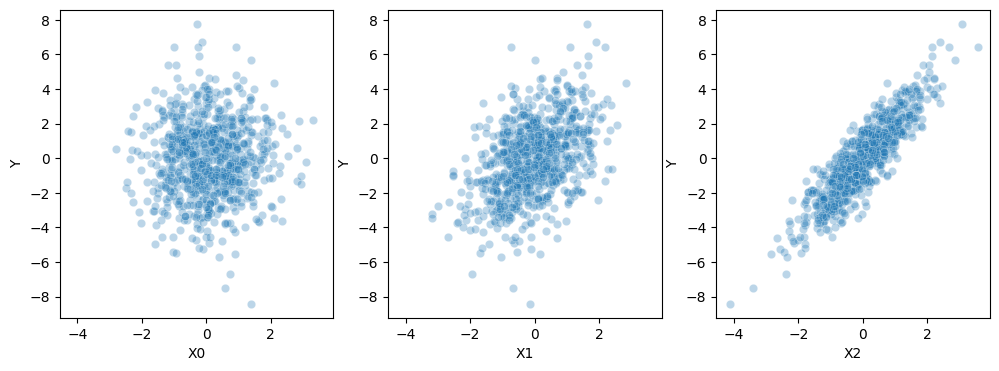

In [5]:
# 可視化
var_names = [f"X{j}" for j in range(3)]
plot_scatter(X_train,y_train, var_names)

In [6]:
from sklearn.linear_model import LinearRegression

def plot_bar(variables, values, title=None, xlabel=None, ylabel=None):
    """回帰係数の大きさを確認する棒グラフ"""
    
    fig, ax = plt.subplots()
    ax.barh(variables, values)
    ax.set(xlabel=xlabel, ylabel=ylabel, xlim=(0, None))
    fig.suptitle(title)
    
    fig.show()

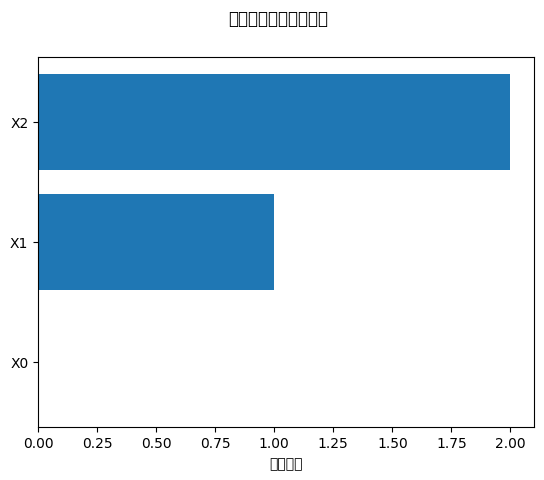

In [7]:
# 線形回帰モデルの学習
lm = LinearRegression().fit(X_train, y_train)

# 回帰係数の可視化
plot_bar(var_names, lm.coef_, "線形回帰係数の大きさ", "回帰係数")

## Permutation Feature Importance(PFI)

In [8]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from PFI import PermutationFeatureImportance

rf = RandomForestRegressor(n_jobs=-1, random_state=42).fit(X_train,y_train)

# 予測精度を確認
print(f"R2: {r2_score(y_test, rf.predict(X_test)):.2f}")

R2: 0.99


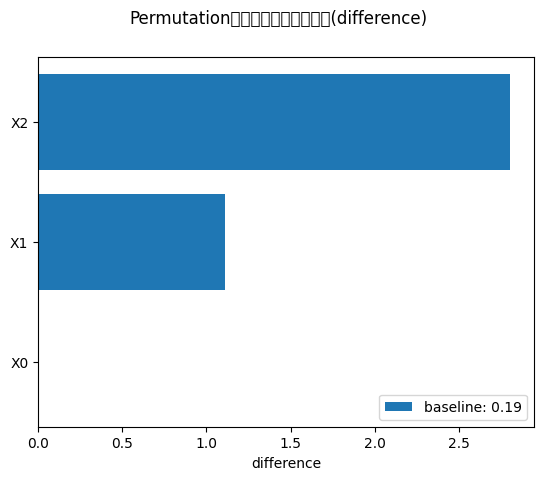

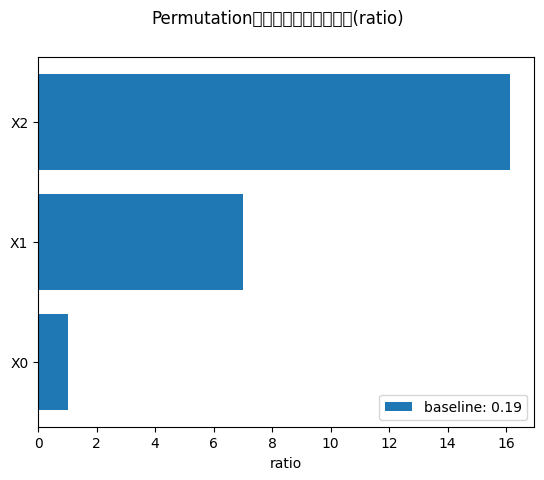

In [9]:
# PFIを計算して可視化
pfi = PermutationFeatureImportance(rf, X_test, y_test, var_names)
pfi.permutation_feature_importance()
pfi.plot(importance_type="difference")
pfi.plot(importance_type="ratio")

## Grouped Permutation Feature Importance (GPFI)

In [10]:
# 特徴量X2と全く同じ特徴量を追加
X_train2 = np.concatenate([X_train,X_train[:,[2]]], axis=1)

# 新しいtrainデータをもとに学習
rf = RandomForestRegressor(n_jobs=-1, random_state=42).fit(X_train2,y_train)

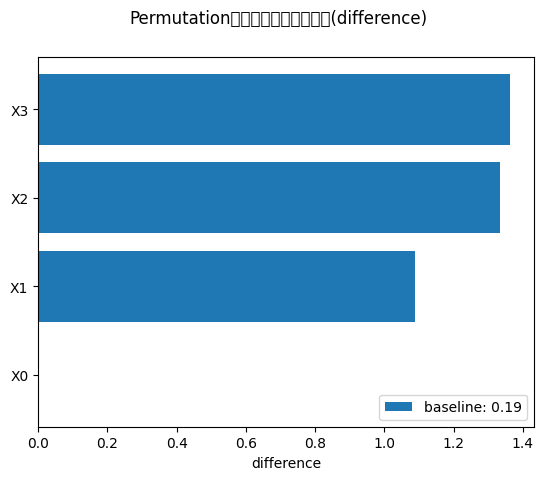

In [11]:
from GPFI import GroupedPermutationFeatureImportance

# テストデータにも同様に特徴量X2とまったく同じ値をとる特徴量X3を作る。
X_test2 = np.concatenate([X_test, X_test[:, [2]]], axis=1)

gpfi = GroupedPermutationFeatureImportance(
    rf, X_test2, y_test, ["X0", "X1", "X2", "X3"]
)

# var_groupsを指定しなければ通常のPFIが計算される
gpfi.permutation_feature_importance()

# 可視化
gpfi.plot()

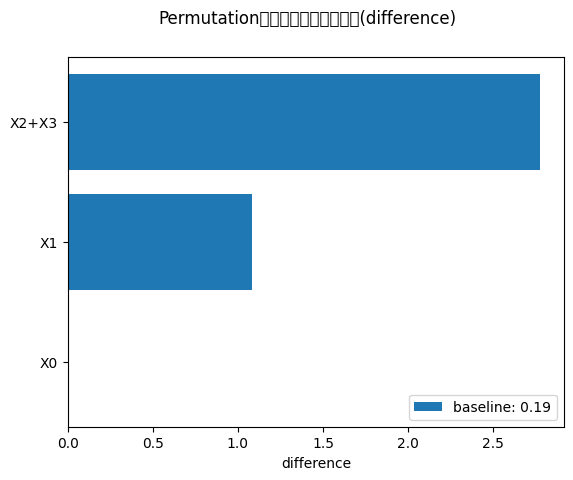

In [12]:
# X2とX3はまとめてシャッフルする
gpfi.permutation_feature_importance(var_groups=[["X0"],["X1"],["X2","X3"]])
gpfi.plot()

## 3.6 疑似相関を考える

In [14]:
# シュミレーションデータの設定
N=1000
mu=np.zeros(3)
Sigma=np.array(
    [[1, 0.95, 0],
    [0.95, 1, 0],
    [0, 0, 1]]
)
beta=np.array([1,0,0])

X_train, X_test, y_train, y_test = generate_simulation_data(N, beta, mu, Sigma)

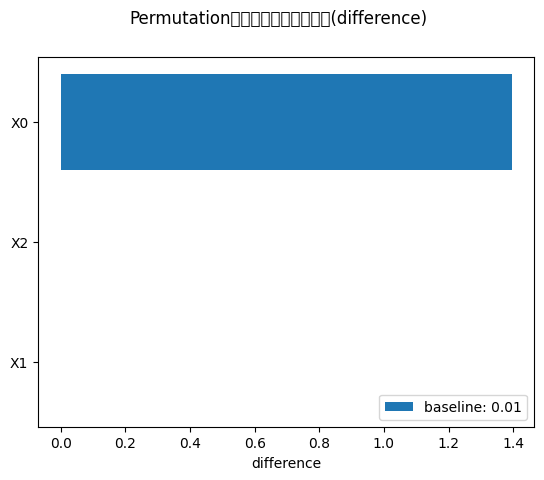

In [16]:
# 全特徴量を使ってRandom Forestの予測モデル構築
rf = RandomForestRegressor(n_jobs=-1, random_state=42).fit(X_train,y_train)

# PFIを計算
pfi = PermutationFeatureImportance(rf, X_test, y_test, var_names)
pfi.permutation_feature_importance()

# PFIを可視化
pfi.plot(importance_type="difference")

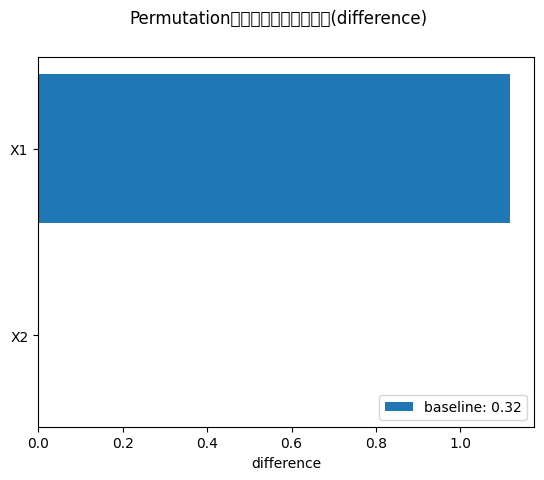

In [17]:
# # X0は使わずRandom Forestの予測モデルを構築
rf = RandomForestRegressor(n_jobs=-1, random_state=42).fit(X_train[:, [1, 2]], y_train)

# PFIを計算。X0は使わない
pfi = PermutationFeatureImportance(rf, X_test[:, [1, 2]], y_test, ["X1", "X2"])
pfi.permutation_feature_importance()

# PFIを可視化
pfi.plot(importance_type="difference")

## 3.8 ボストンデータで実践

In [21]:
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.datasets import load_boston
import joblib

boston = load_boston()

X = pd.DataFrame(data=boston["data"], columns=boston["feature_names"])
y = boston["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

joblib.dump([X_train,X_test,y_train,y_test],filename="../data/boston_housing.pkl")

['../data/boston_housing.pkl']

In [23]:
rf = RandomForestRegressor(n_jobs=-1, random_state=42)

rf.fit(X_train, y_train)

# モデルの書き出し
joblib.dump(rf, "../data/boston_housing_rf.pkl")

['../data/boston_housing_rf.pkl']

In [24]:
X_train, X_test, y_train, y_test = joblib.load("../data/boston_housing.pkl")
rf = joblib.load("../data/boston_housing_rf.pkl")

In [30]:
from sklearn.inspection import permutation_importance

# PFIを計算
pfi = permutation_importance(
    estimator=rf,
    X=X_test,
    y=y_test,
    scoring="neg_root_mean_squared_error",#RMSE
    n_repeats=5,#シャッフルの数
    n_jobs=-1,
    random_state=42
)
pfi

{'importances_mean': array([4.23102691e-01, 5.22415926e-03, 3.22609194e-02, 1.97992191e-03,
        4.09976466e-01, 3.69468378e+00, 1.68864822e-01, 9.96844340e-01,
        1.62260757e-02, 8.56175910e-02, 3.61383249e-01, 1.20464518e-02,
        3.44706742e+00]),
 'importances_std': array([0.03584864, 0.00195564, 0.00547221, 0.00267742, 0.05174084,
        0.10293097, 0.03387241, 0.52260892, 0.01086834, 0.03258306,
        0.07781592, 0.04044501, 0.54742706]),
 'importances': array([[ 3.79576282e-01,  3.95888174e-01,  4.83996044e-01,
          4.23905794e-01,  4.32147159e-01],
        [ 5.68955320e-03,  3.87909137e-03,  7.83476697e-03,
          6.45434309e-03,  2.26304165e-03],
        [ 3.06735554e-02,  3.43561931e-02,  2.44321932e-02,
          3.06901880e-02,  4.11524674e-02],
        [ 6.77709365e-03,  2.20849913e-03, -4.76307445e-04,
         -6.16995486e-04,  2.00731972e-03],
        [ 3.66443568e-01,  3.47749341e-01,  4.85781558e-01,
          4.51629597e-01,  3.98278268e-01],
  

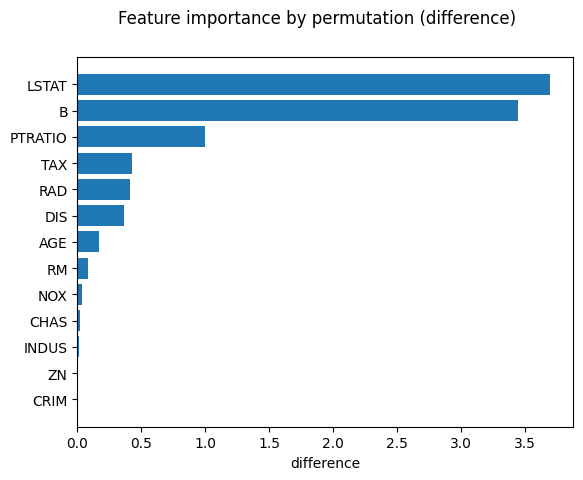

In [32]:
# PFIを可視化
df_pfi = pd.DataFrame(
    data={"var_name": X_test.columns, "importance": pfi["importances_mean"]}
)

plot_bar(
    df_pfi["var_name"],
    df_pfi["importance"].sort_values(),
    xlabel="difference",
    title="Feature importance by permutation (difference)"
)